In [1]:
import numpy as np
import time
import pandas as pd
from scipy.sparse import csr_matrix
from netreco import Reconstructor, ss_sim
from netreco.Reconstructor import Profile
import matplotlib.pyplot as plt

R = 100

In [2]:
%matplotlib inline
A = [
    [0.75, 0, 0, 0, 0, 1.2],
    [-.1, -.35, 0, 0, 0, 0],
    [0, 0, .85, -1, 0, 0],
    [0, -.73, 0, .95, 0, 0],
    [0, 0, .43, 0, -.6, 0],
    [0, 0, 0, 0, .2, .55]

]
A = np.array(A)
B = [
    [1.4, 0, 0],
    [0, -.25, 0],
    [0, 0, 0.75],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
]
B = np.array(B)
C = [
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0]
]
C = np.array(C)

# u = pd.read_csv('../scripts/u.csv', header=None).values
u = np.random.rand(R * 6 + 1, 3)
y = ss_sim(A, B, C, u)

Pbool = np.identity(3)

real_params = {
    (1, 2): [0, 0.5],
    (1, 3): [.51, .75, -.11, -.6, -.816, .55],
    (2, 1): [.286, -.35],
    (2, 3): [0, 0.5],
    (3, 1): [0, 0.5],
    (3, 2): [7.684, .95, -8.588, .85]
}

In [3]:
def run(std, robust, plot=False):
    np.random.seed()  # Make sure each rep has a different random seed
    recon = Reconstructor(debug=False, r=R, Pbool=Pbool, bounds=20, order=4, real_params=real_params, robust=robust)
    
    bogus = np.zeros(R)
    
    ut = u + np.random.randn(u.shape[0], u.shape[1]) * std
    yt = y + np.random.randn(u.shape[0], u.shape[1]) * std
    # print(ut[0:5, :])
    
    params = recon.measured(yt, ut, plot=plot, titles=[])    
    
    ijs = [(1,2), (1,3), (2,1), (2,3), (3,1), (3,2)]
    
    err = 0
    for ij in ijs:
        i = ij[0] 
        j = ij[1] 
    
        fitparams = params[i - 1][j - 1]
    
        err_bogus, real = recon._fiterr(real_params[ij], bogus, True)
        ij_err, rcst = recon._fiterr(fitparams, real, True)    
        
        err += ij_err
        
    err = err / float(len(ijs))   
        
    if plot:
        plt.plot()
        # plt.figure()
        # plt.plot(range(R), real, label='Actual Parameters')
        # plt.plot(range(R), rcst, label='Reconstructed Parameters')
        # plt.legend()
        
    return err

In [4]:
from multiprocessing import Pool
from functools import partial

rs = {}
step = 0.1
pwrs = np.arange(-2, 1.25, .25)
# rng = [10**pwr for pwr in pwrs]
# rng = [0, 0.01, 0.015, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1, 1.5, 2, 3, 5, 10]
rng = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]

reps = 20

def inner(rep, std):
    
    print('Running {} - {}'.format(std, rep + 1))
    van = run(std, False, plot=False)
    rob = run(std, True, plot=False)
    
    rs = {
        'Vanilla': van,
        'Robust': rob
    }
    
    print('\tDone {} - {}. Vanilla = {:.3f}; Robust = {:.3f}'.format(std, rep + 1, van, rob))
    return rs

    
for std in rng:
    f = partial(inner, std=std)
    
    p = Pool(reps)
    rss = p.map(f, range(reps))
    
    # rss = map(f, range(reps))
    
    rs[std] = {
        'Vanilla': sum([item['Vanilla'] for item in rss]) / float(reps),
        'Robust': sum([item['Robust'] for item in rss]) / float(reps)
    }
    
    # for rep in range(reps):
    #     f(rep)        
        
    # rs[std]['Vanilla'] /= float(reps)
    # rs[std]['Robust'] /= float(reps)    

Running 0.001 - 1
Running 0.001 - 10
Running 0.001 - 9
Running 0.001 - 11
Running 0.001 - 13
Running 0.001 - 14
Running 0.001 - 12
Running 0.001 - 16
Running 0.001 - 15
Running 0.001 - 17
Running 0.001 - 18
Running 0.001 - 20
Running 0.001 - 19
Running 0.001 - 4
Running 0.001 - 8
Running 0.001 - 6
Running 0.001 - 3
Running 0.001 - 5
Running 0.001 - 7
Running 0.001 - 2
	Done 0.001 - 11. Vanilla = 0.002; Robust = 0.010
	Done 0.001 - 17. Vanilla = 0.002; Robust = 0.007
	Done 0.001 - 12. Vanilla = 0.002; Robust = 0.008
	Done 0.001 - 3. Vanilla = 0.003; Robust = 0.010
	Done 0.001 - 6. Vanilla = 0.001; Robust = 0.009
	Done 0.001 - 2. Vanilla = 0.003; Robust = 0.007
	Done 0.001 - 7. Vanilla = 0.001; Robust = 0.008
	Done 0.001 - 1. Vanilla = 0.002; Robust = 0.010
	Done 0.001 - 16. Vanilla = 0.002; Robust = 0.006
	Done 0.001 - 4. Vanilla = 0.002; Robust = 0.009
	Done 0.001 - 8. Vanilla = 0.002; Robust = 0.007
	Done 0.001 - 5. Vanilla = 0.002; Robust = 0.007
	Done 0.001 - 18. Vanilla = 0.002; Ro

          Robust   Vanilla
0.001   0.008140  0.002242
0.002   0.010436  0.003607
0.005   0.012615  0.008275
0.010   0.020157  0.014961
0.020   0.038341  0.028372
0.050   0.093207  0.090671
0.100   0.172247  0.151544
0.200   0.218736  0.213249
0.500   0.230285  0.239595
1.000   0.236503  0.237969
2.000   0.235935  0.235653
5.000   0.233146  0.238744
10.000  0.232355  0.238497


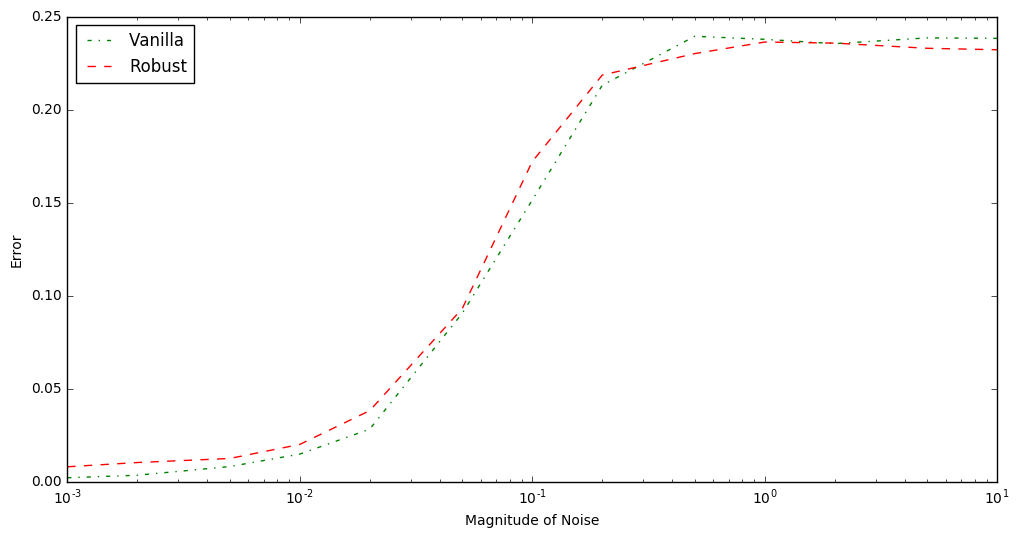

In [5]:
df = pd.DataFrame(rs).transpose()
print(df)

plt.figure(figsize=(12, 6))
plt.semilogx(list(df.axes[0]), list(df['Vanilla']), color='g', linestyle='-.', label='Vanilla')
plt.plot(list(df.axes[0]), list(df['Robust']), color='r', linestyle='--', label='Robust')
plt.xlabel('Magnitude of Noise')
plt.ylabel('Error')
plt.legend(loc=2)